In [133]:
import os
import sys
import pickle
import time

PROJECT_ROOT = os.path.abspath('..')
sys.path.append(PROJECT_ROOT)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from tqdm import tqdm

from sleeprnn.helpers.reader import load_dataset
from sleeprnn.common import constants, viz, pkeys
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.detection.predicted_dataset import PredictedDataset
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection import det_utils
from figs_thesis import fig_utils

viz.notebook_full_width()

param_filtering_fn = fig_utils.get_filtered_signal_for_event
param_frequency_fn = fig_utils.get_frequency_by_fft
param_amplitude_fn = fig_utils.get_amplitude_event

RESULTS_PATH = os.path.join(PROJECT_ROOT, 'results')
LETTERS = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']

# Load NSRR dataset and pre-computed predicted dataset

In [ ]:
nsrr = load_dataset(constants.NSRR_SS_NAME, load_checkpoint=True)

In [ ]:
parts_to_load = [0]  # 0 to 11

pred_objects = []
for part in parts_to_load:
    filepath = os.path.join(
        RESULTS_PATH, 'predictions_nsrr_ss',
        'ckpt_20210716_from_20210529_thesis_indata_5cv_e1_n2_train_moda_ss_ensemble_to_e1_n2_train_nsrr_ss',
        'v2_time',
        'prediction_part%d.pkl' % part
    )
    with open(filepath, 'rb') as handle:
        pred_object = pickle.load(handle)
    pred_object.set_parent_dataset(nsrr)
    pred_objects.append(pred_object)

<h1> Dataset de parámetros</h1>

Parámetros no definidos son NaN.

In [2]:
# Filenames of dataset checkpoints
byevent_ckpt_path = os.path.join(
    RESULTS_PATH, 'predictions_nsrr_ss',
    'ckpt_20210716_from_20210529_thesis_indata_5cv_e1_n2_train_moda_ss_ensemble_to_e1_n2_train_nsrr_ss',
    'v2_time',
    'table_byevent.csv'
)
bysubject_ckpt_path = os.path.join(
    RESULTS_PATH, 'predictions_nsrr_ss',
    'ckpt_20210716_from_20210529_thesis_indata_5cv_e1_n2_train_moda_ss_ensemble_to_e1_n2_train_nsrr_ss',
    'v2_time',
    'table_bysubject.csv'
)

In [3]:
params_load_checkpoint = True

# ############################

if params_load_checkpoint:
    print("Loading from checkpoint")
    table_byevent = pd.read_csv(byevent_ckpt_path)
    table_bysubject = pd.read_csv(bysubject_ckpt_path)

else:
    # Perform computation and save checkpoint
    table_byevent = {
        'subject_id': [],
        'mark_id': [],
        'duration': [], 
        'amplitude': [],
        'frequency': [],
    }
    table_bysubject = {
        'subject_id': [],
        'age': [], 
        'female': [],
        'n2_minutes': [],
        'n2_abs_sigma_power': [],
        'n2_rel_sigma_power': [],
        'n2_pl_exponent': [],
        'density': [],
        'duration': [], 
        'amplitude': [],
        'frequency': [],
    }

    min_n2_minutes = 60
    verbose_min_minutes = False

    start_time = time.time()
    print("Generating table of parameters")
    for part_id, predictions in enumerate(pred_objects):
        print("Processing Part %d / %d" % (part_id + 1, len(pred_objects)))
        for subject_id in tqdm(predictions.all_ids):
            n2_pages = predictions.data[subject_id]['n2_pages']
            n2_minutes = n2_pages.size * nsrr.original_page_duration / 60
            if n2_minutes < min_n2_minutes:
                if verbose_min_minutes:
                    print("Skipped by N2 minutes: Subject %s with %d N2 minutes" % (subject_id, n2_minutes))
                continue

            # Now compute parameters
            subject_data = nsrr.read_subject_data(subject_id, exclusion_of_pages=False)
            signal = subject_data['signal']
            age = float(subject_data['age'].item())
            female = int(subject_data['sex'].item() == 'f')

            # By-subject spectral parameters
            signal_n2 = signal.reshape(-1, nsrr.fs * nsrr.original_page_duration)[n2_pages].flatten()
            freq, power = utils.power_spectrum_by_sliding_window(signal_n2, nsrr.fs, window_duration=5)
            # a) Absolute sigma power 
            n2_abs_sigma_power = power[(freq >= 11) & (freq <= 16)].mean()
            # b) Relative sigma power (as in Lacourse)
            n2_broad_power = power[(freq >= 4.5) & (freq <= 30)].mean()
            n2_rel_sigma_power = n2_abs_sigma_power / n2_broad_power
            # c) Power law exponent 2-30 Hz without sigma band (same as exclusion process)
            locs_to_use = np.where(((freq >= 2) & (freq < 10)) | ((freq > 17) & (freq <= 30)))[0]
            log_x = np.log(freq[locs_to_use])
            log_y = np.log(power[locs_to_use])
            n2_pl_exponent, _, _, _, _ = scipy.stats.linregress(log_x, log_y)

            # Spindle parameters
            marks = predictions.get_subject_stamps(subject_id, pages_subset='n2')
            n_marks = marks.shape[0]
            density = n_marks / n2_minutes  # epm
            if n_marks == 0:
                # Dummy entries
                be_subject_id = [subject_id]
                be_mark_id = [np.nan]
                be_duration = [np.nan]
                be_amplitude = [np.nan]
                be_frequency = [np.nan]
            else:
                be_subject_id = [subject_id] * n_marks
                be_mark_id = np.arange(n_marks)

                be_duration = (marks[:, 1] - marks[:, 0] + 1) / nsrr.fs

                filt_signal = param_filtering_fn(signal, nsrr.fs, constants.SPINDLE)
                signal_events = [filt_signal[e[0]:(e[1]+1)] for e in marks]

                be_amplitude = np.array([
                    param_amplitude_fn(s, nsrr.fs, constants.SPINDLE) for s in signal_events
                ])

                be_frequency = np.array([
                    param_frequency_fn(s, nsrr.fs) for s in signal_events
                ])

            # By-subject averages
            bs_duration = np.mean(be_duration)
            bs_amplitude = np.mean(be_amplitude)
            bs_frequency = np.mean(be_frequency)

            # Save parameters
            table_byevent['subject_id'].append(be_subject_id)
            table_byevent['mark_id'].append(be_mark_id)
            table_byevent['duration'].append(be_duration)
            table_byevent['amplitude'].append(be_amplitude)
            table_byevent['frequency'].append(be_frequency)

            table_bysubject['subject_id'].append(subject_id)
            table_bysubject['age'].append(age)
            table_bysubject['female'].append(female)
            table_bysubject['n2_minutes'].append(n2_minutes)
            table_bysubject['n2_abs_sigma_power'].append(n2_abs_sigma_power)
            table_bysubject['n2_rel_sigma_power'].append(n2_rel_sigma_power)
            table_bysubject['n2_pl_exponent'].append(n2_pl_exponent)
            table_bysubject['density'].append(density)
            table_bysubject['duration'].append(bs_duration)
            table_bysubject['amplitude'].append(bs_amplitude)
            table_bysubject['frequency'].append(bs_frequency) 
    end_time = time.time()
    et_time = (end_time - start_time) / 60  # minutes
    print("Elapsed time: %1.4f minutes" % et_time)
    
    for key in table_byevent:
        table_byevent[key] = np.concatenate(table_byevent[key])
    table_byevent = pd.DataFrame.from_dict(table_byevent)
    table_bysubject = pd.DataFrame.from_dict(table_bysubject)
   
    # Save checkpoint
    print("Saving checkpoint")
    table_byevent.to_csv(byevent_ckpt_path, index=False)
    table_bysubject.to_csv(bysubject_ckpt_path, index=False)
    print("Done.")

Loading from checkpoint


In [4]:
print(table_byevent.shape)
table_byevent.head()

(2319290, 5)


,subject_id,mark_id,duration,amplitude,frequency
0,ccshs-trec-1800034,0.0,0.44,24.371809,13.9
1,ccshs-trec-1800034,1.0,0.72,28.900696,14.8
2,ccshs-trec-1800034,2.0,1.48,23.536839,15.4
3,ccshs-trec-1800034,3.0,0.60,26.453024,15.2
4,ccshs-trec-1800034,4.0,0.64,68.478527,14.3


In [5]:
print(table_bysubject.shape)
table_bysubject.head()

(11224, 11)


,subject_id,age,female,n2_minutes,n2_abs_sigma_power,n2_rel_sigma_power,n2_pl_exponent,density,duration,amplitude,frequency
0,ccshs-trec-1800034,17.40,1,163.0,0.386454,1.859941,-1.279945,4.969325,1.116099,46.538635,13.508025
1,ccshs-trec-1800038,17.40,1,217.5,0.308670,1.510728,-1.136783,4.422989,1.102703,39.584287,12.762682
2,ccshs-trec-1800065,17.68,1,222.5,0.226842,1.522630,-1.228495,3.038202,0.955740,31.335450,12.873225
3,ccshs-trec-1800074,17.86,1,214.0,0.284249,1.389635,-1.336513,2.901869,0.874654,40.135913,13.146055
4,ccshs-trec-1800078,17.77,0,238.0,0.253408,1.328701,-1.223523,2.630252,0.834952,32.414402,13.200639


# Final NSRR composition statistics

Measure number of subjects and N2 hours of each subdataset (consider also zero marks subjects because this table should be independent from the detector). The idea is to say: the dataset was reduced from X subjects/hours to Y subjects/hours. On this dataset, there are Z total spindle detections to analyze.

In [8]:
table_bysubject['origin'] = [s.split("-")[0] for s in table_bysubject.subject_id.values]
table_bysubject.head()

,subject_id,age,female,n2_minutes,n2_abs_sigma_power,n2_rel_sigma_power,n2_pl_exponent,density,duration,amplitude,frequency,origin
0,ccshs-trec-1800034,17.40,1,163.0,0.386454,1.859941,-1.279945,4.969325,1.116099,46.538635,13.508025,ccshs
1,ccshs-trec-1800038,17.40,1,217.5,0.308670,1.510728,-1.136783,4.422989,1.102703,39.584287,12.762682,ccshs
2,ccshs-trec-1800065,17.68,1,222.5,0.226842,1.522630,-1.228495,3.038202,0.955740,31.335450,12.873225,ccshs
3,ccshs-trec-1800074,17.86,1,214.0,0.284249,1.389635,-1.336513,2.901869,0.874654,40.135913,13.146055,ccshs
4,ccshs-trec-1800078,17.77,0,238.0,0.253408,1.328701,-1.223523,2.630252,0.834952,32.414402,13.200639,ccshs


In [9]:
origin_stats = table_bysubject[["subject_id", "origin"]].groupby(by="origin").count()
origin_stats['hours'] = table_bysubject[["n2_minutes", "origin"]].groupby(by="origin").sum() / 60  # hours
origin_stats['min_age'] = table_bysubject[["age", "origin"]].groupby(by="origin").min()
origin_stats['max_age'] = table_bysubject[["age", "origin"]].groupby(by="origin").max()
origin_stats['female'] = table_bysubject[["female", "origin"]].groupby(by="origin").mean() * 100
print(origin_stats)
print("")
print("Total:")
print("Number of subjects:", len(table_bysubject))
print("Number of hours: %1.6f" % (table_bysubject["n2_minutes"].sum() / 60))
# print(origin_stats[["subject_id", "hours"]].sum())
print("Age:", table_bysubject["age"].min(), table_bysubject["age"].max())
print("Female:", 100 * table_bysubject["female"].mean())

        subject_id         hours    min_age   max_age      female
origin                                                           
ccshs          513   1734.691667  16.140000  19.56000   49.512671
cfs            711   2271.033333   6.765229  88.53388   54.992968
chat          1053   2271.208333   4.500000  10.00000   52.706553
mros          2862  10158.808333  67.000000  90.00000    0.000000
shhs1         5648  18755.566667  39.000000  90.00000   52.283994
sof            437   1356.741667  75.000000  90.00000  100.000000

Total:
Number of subjects: 11224
Number of hours: 36548.050000
Age: 4.5 90.0
Female: 40.89451176051318


In [10]:
print("Subjects without detections:")
table_bysubject[table_bysubject['density'] <= 0]

Subjects without detections:


,subject_id,age,female,n2_minutes,n2_abs_sigma_power,n2_rel_sigma_power,n2_pl_exponent,density,duration,amplitude,frequency,origin
487,shhs1-200721,61.00000,0,87.5,0.120748,1.205779,-1.016663,0.0,NaN,NaN,NaN,shhs1
2965,cfs-visit5-801177,76.38056,0,62.0,0.226105,1.084217,-1.244129,0.0,NaN,NaN,NaN,cfs
3328,mros-visit1-aa5843,73.00000,0,81.5,0.157315,0.821180,-1.475405,0.0,NaN,NaN,NaN,mros
4022,chat-baseline-nonrandomized-300577,4.80000,1,137.0,0.115866,0.846627,-1.507882,0.0,NaN,NaN,NaN,chat
7102,mros-visit1-aa3593,68.00000,0,170.5,0.130469,1.094755,-1.068446,0.0,NaN,NaN,NaN,mros
10151,shhs1-200323,67.00000,0,142.5,0.151972,1.093194,-1.007131,0.0,NaN,NaN,NaN,shhs1


In [11]:
min_detections = 10

event_counts = np.round(table_bysubject["n2_minutes"] * table_bysubject["density"])
subjects_with_few_detections = np.sum(event_counts < min_detections)
print("Subjects with less than %d detections: %d (%1.4f%%)" % (
    min_detections, subjects_with_few_detections, 100 * subjects_with_few_detections / len(table_bysubject)))

Subjects with less than 10 detections: 338 (3.0114%)


# Gráficos por evento (sin agrupar por demografía)

In [6]:
table_byevent_valid = table_byevent.dropna()

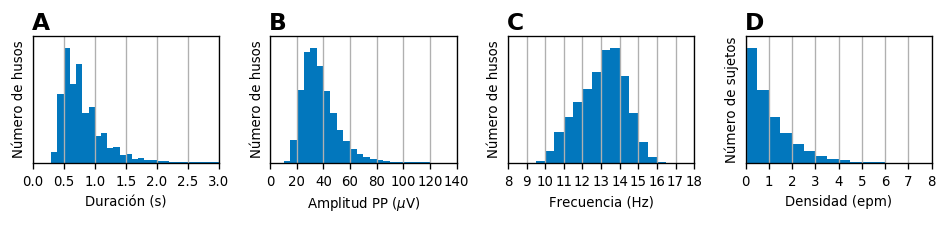

In [161]:
fig, axes = plt.subplots(1, 4, figsize=(8, 2), dpi=120)

show_average = False

factor_to_lim = 1.35 if show_average else 1.1

ax = axes[0]
n, _, _ = ax.hist(table_byevent_valid.duration.values, bins=np.arange(0.3, 3.0 + 0.001, 0.1), color=viz.PALETTE['blue'])
max_count = np.max(n)
ax.set_ylim([0, factor_to_lim * max_count])
ax.set_xlabel("Duración (s)", fontsize=8)
mean_value = np.mean(table_byevent_valid.duration.values)
if show_average:
    ax.axvline(mean_value, linewidth=0.8, color="k", linestyle="--", label="Promedio %1.2f s" % mean_value)
ax.set_xticks(np.arange(0, 3 + 0.001, 0.5))
ax.set_xlim([0, 3])
ax.set_ylabel("Número de husos", fontsize=8)

ax = axes[1]
n, _, _ = ax.hist(table_byevent_valid.amplitude.values, bins=np.arange(0, 135 + 0.001, 5), color=viz.PALETTE['blue'])
max_count = np.max(n)
ax.set_ylim([0, factor_to_lim * max_count])
ax.set_xlabel("Amplitud PP ($\mu$V)", fontsize=8)
mean_value = np.mean(table_byevent_valid.amplitude.values)
if show_average:
    ax.axvline(mean_value, linewidth=0.8, color="k", linestyle="--", label="Promedio %1.1f $\mu$V" % mean_value)
ax.set_xticks(np.arange(0, 140 + 0.001, 20))
ax.set_xlim([0, 140])
ax.set_ylabel("Número de husos", fontsize=8)

ax = axes[2]
n, _, _ = ax.hist(table_byevent_valid.frequency.values, bins=np.arange(8.5, 17.5 + 0.001, 0.5), color=viz.PALETTE['blue'])
max_count = np.max(n)
ax.set_ylim([0, factor_to_lim * max_count])
ax.set_xlabel("Frecuencia (Hz)", fontsize=8)
mean_value = np.mean(table_byevent_valid.frequency.values)
if show_average:
    ax.axvline(mean_value, linewidth=0.8, color="k", linestyle="--", label="Promedio %1.1f Hz" % mean_value)
ax.set_xticks(np.arange(8, 18 + 0.001, 1))
ax.set_xlim([8, 18])
ax.set_ylabel("Número de husos", fontsize=8)

# oscilaciones
#ax = axes[3]
#oscils = table_byevent_valid.frequency.values * table_byevent_valid.duration.values
#n, _, _ = ax.hist(oscils, color=viz.PALETTE['blue'], bins=np.arange(0, 50 + 0.001, 2.5))
#max_count = np.max(n)
#ax.set_ylim([0, factor_to_lim * max_count])
#ax.set_xlabel("Oscilaciones", fontsize=8)
#mean_value = np.mean(oscils)
#ax.axvline(mean_value, linewidth=0.8, color="k", linestyle="--", label="Promedio %1.1f" % mean_value)
#ax.set_xticks(np.arange(0, 50 + 0.001, 5))
#ax.set_xlim([0, 50])

# Densidad 
ax = axes[3]
n, _, _ = ax.hist(table_bysubject.density.values, color=viz.PALETTE['blue'], bins=np.arange(0, 8 + 0.001, 0.5))
max_count = np.max(n)
ax.set_ylim([0, factor_to_lim * max_count])
ax.set_xlabel("Densidad (epm)", fontsize=8)
mean_value = np.mean(table_bysubject.density.values)
if show_average:
    ax.axvline(mean_value, linewidth=0.8, color="k", linestyle="--", label="Promedio %1.1f epm" % mean_value)
ax.set_xticks(np.arange(0, 8 + 0.001, 1))
ax.set_xlim([0, 8])
ax.set_ylabel("Número de sujetos", fontsize=8)


for i_ax, ax in enumerate(axes.flatten()):
    ax.tick_params(labelsize=8)
    ax.set_yticks([])
    ax.grid()
    if show_average:
        ax.legend(loc="upper right", fontsize=8, frameon=True)
    ax.text(
        x=-0.01, y=1.05, fontsize=14, s=r"$\bf{%s}$" % LETTERS[i_ax],
        ha="left", transform=ax.transAxes)
    
plt.tight_layout()

plt.show()

# Gráficos de densidad vs potencia en banda sigma

/home/ntapia/miniconda3/envs/tf/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:391: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,


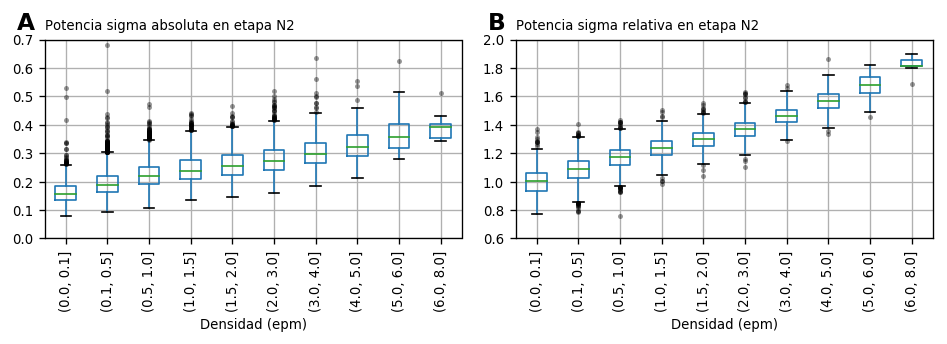

In [162]:
df = table_bysubject.copy()
df['density_bin'] = pd.cut(table_bysubject.density, bins=[0, 0.1, 0.5, 1.0, 1.5, 2, 3, 4, 5, 6, 8])

fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=120)
df.boxplot(
    column=["n2_abs_sigma_power", "n2_rel_sigma_power"],
    by="density_bin", 
    ax=axes, fontsize=8, rot=90,
    flierprops=dict(markersize=3, marker='o', markerfacecolor="k", alpha=0.4, markeredgewidth=0)
)

fig.suptitle('')
for i_ax, ax in enumerate(axes):
    ax.set_title('')
    ax.set_xlabel("Densidad (epm)", fontsize=8)
    ax.text(
        x=-0.07, y=1.05, fontsize=14, s=r"$\bf{%s}$" % LETTERS[i_ax],
        ha="left", transform=ax.transAxes)
    
axes[0].set_title("Potencia sigma absoluta en etapa N2", fontsize=8, loc="left")
axes[0].set_ylim([0, 0.7])
axes[1].set_title("Potencia sigma relativa en etapa N2", fontsize=8, loc="left")
axes[1].set_ylim([0.6, 2.0])
    
plt.tight_layout()
    
plt.show()

In [163]:
np.sum(table_bysubject.density <= 0.1)

837

In [164]:
100 * np.sum(table_bysubject.density <= 0.1) / len(table_bysubject)

7.457234497505346

# Gráficos by-subject con suficientes detecciones

/home/ntapia/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


[ 476.   33.  284.   27.   19.   15.   17.  186.  206.  317.  439.  412.
  672. 1296. 1083.  624.  273.]
[534.  34. 292.  34.  21.  14.  26. 219. 265. 355. 519. 408. 394. 408.
 401. 418. 165.]


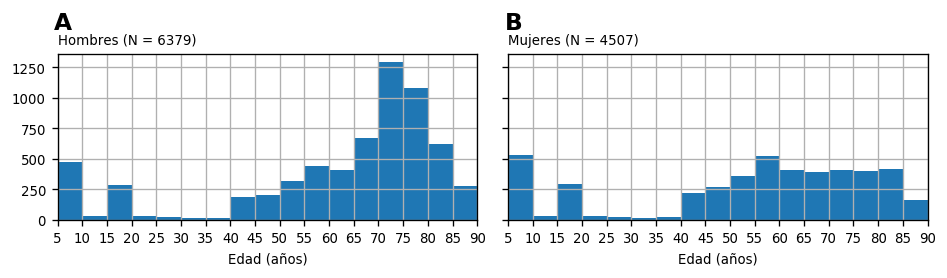

In [176]:
# Demographics of subjects with enough detections
min_detections = 10
event_counts = np.round(table_bysubject["n2_minutes"] * table_bysubject["density"])
enough_dets = table_bysubject[event_counts >= min_detections]

# Those with less than 5 years are three subjects with 4.5, 4.9 and 4.9 y.o.. For statistics purposes those
# subjects will be within the bin containing 5 years old.
enough_dets["age"] = np.clip(enough_dets["age"], a_min=5, a_max=None)

ages_m = enough_dets[enough_dets.female == 0]["age"].values
ages_f = enough_dets[enough_dets.female == 1]["age"].values

bins = np.arange(5, 90 + 0.001, 5)
fig, axes = plt.subplots(1, 2, figsize=(8, 2.5), dpi=120, sharey=True)

ax = axes[0]
n, _, _ = ax.hist(ages_m, bins=bins)
ax.set_title("Hombres (N = %d)" % len(ages_m), fontsize=8, loc="left")
print(n)

ax = axes[1]
n, _, _ = ax.hist(ages_f, bins=bins)
ax.set_title("Mujeres (N = %d)" % len(ages_f), fontsize=8, loc="left")
print(n)

for i_ax, ax in enumerate(axes):
    ax.tick_params(labelsize=8)
    ax.set_xlabel("Edad (años)", fontsize=8)
    ax.set_xticks(bins)
    ax.grid()
    ax.set_xlim([bins[0], bins[-1]])
    ax.text(
        x=-0.01, y=1.15, fontsize=14, s=r"$\bf{%s}$" % LETTERS[i_ax],
        ha="left", transform=ax.transAxes)

plt.tight_layout()
plt.show()

In [177]:
# by-subject params vs demographics
# params to vary: duration, amplitude, frequency, density

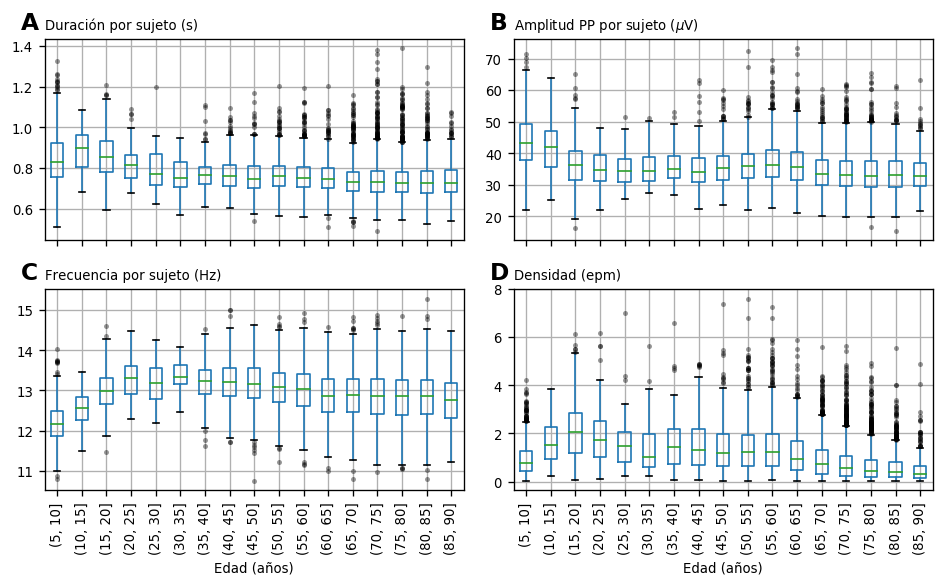

In [189]:
# Age differences

df = enough_dets.copy()
df['age_bin'] = pd.cut(enough_dets.age, bins=np.arange(5, 90 + 0.001, 5).astype(np.int32))

fig, axes = plt.subplots(2, 2, figsize=(8, 5), dpi=120, sharex=True)
df.boxplot(
    column=["duration", "amplitude", "frequency", "density"],
    by="age_bin", 
    ax=axes, fontsize=8, rot=90,
    flierprops=dict(markersize=3, marker='o', markerfacecolor="k", alpha=0.4, markeredgewidth=0)
)
fig.suptitle('')
for i_ax, ax in enumerate(axes.flatten()):
    ax.tick_params(labelsize=8)
    ax.set_title('')
    ax.set_xlabel('')
    ax.text(
        x=-0.06, y=1.05, fontsize=14, s=r"$\bf{%s}$" % LETTERS[i_ax],
        ha="left", transform=ax.transAxes)
axes[0, 0].set_title("Duración por sujeto (s)", fontsize=8, loc="left")
axes[0, 1].set_title("Amplitud PP por sujeto ($\mu$V)", fontsize=8, loc="left")
axes[1, 0].set_title("Frecuencia por sujeto (Hz)", fontsize=8, loc="left")
axes[1, 1].set_title("Densidad (epm)", fontsize=8, loc="left")
axes[1, 0].set_xlabel("Edad (años)", fontsize=8)
axes[1, 1].set_xlabel("Edad (años)", fontsize=8)
    
plt.tight_layout()
plt.show()

/home/ntapia/miniconda3/envs/tf/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:391: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,
/home/ntapia/miniconda3/envs/tf/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:391: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,


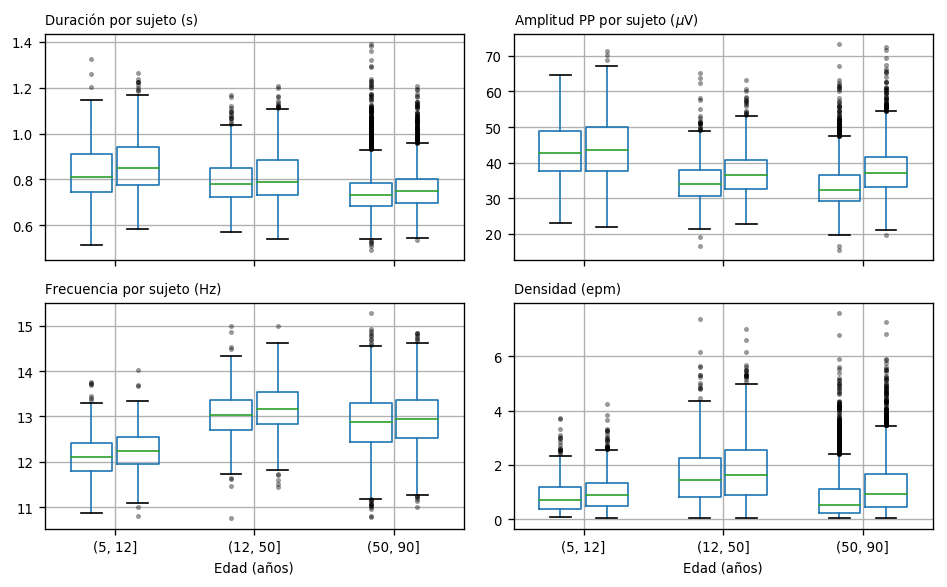

In [203]:
# sex differences

df = enough_dets.copy()
df['age_bin'] = pd.cut(enough_dets.age, bins=[5, 12, 50, 90])

fig, axes = plt.subplots(2, 2, figsize=(8, 5), dpi=120, sharex=True)
df[df.female==0].boxplot(
    column=["duration", "amplitude", "frequency", "density"],
    by=["age_bin"], 
    fontsize=8, rot=0, ax=axes,
    flierprops=dict(markersize=3, marker='o', markerfacecolor="k", alpha=0.4, markeredgewidth=0),
    positions=[0.75, 2.25, 3.75],
)
df[df.female==1].boxplot(
    column=["duration", "amplitude", "frequency", "density"],
    by=["age_bin"], 
    fontsize=8, rot=0, ax=axes,
    flierprops=dict(markersize=3, marker='o', markerfacecolor="k", alpha=0.4, markeredgewidth=0),
    positions=[1.25, 2.75, 4.25],
)

fig.suptitle('')
for i_ax, ax in enumerate(axes.flatten()):
    ax.tick_params(labelsize=8)
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_xlim([0.25, 4.75])
    ax.set_xticks([1, 2.5, 4])
axes[0, 0].set_title("Duración por sujeto (s)", fontsize=8, loc="left")
axes[0, 1].set_title("Amplitud PP por sujeto ($\mu$V)", fontsize=8, loc="left")
axes[1, 0].set_title("Frecuencia por sujeto (Hz)", fontsize=8, loc="left")
axes[1, 1].set_title("Densidad (epm)", fontsize=8, loc="left")
axes[1, 0].set_xlabel("Edad (años)", fontsize=8)
axes[1, 1].set_xlabel("Edad (años)", fontsize=8)

plt.tight_layout()
plt.show()